# Proximal gradient descent

In this lab, the goal is to implement proximal gradient descent, and look at its behavior. We will implement it for the Lasso, and some $\ell_1$ regularized problems.


In the following, `X` is a $n\times p$ matrix and `y` a vector of size $n$.

In [66]:
import numpy as np
import matplotlib.pyplot as plt

n = 5
p = 10
X = np.random.randn(n, p)
y = np.random.randn(n)
w = np.random.randn(p)
lbda = 0.5

**Exercise 1**: Implement an algorithm that computes the value of the lasso function, and the gradient of the smooth part. We recall that the lasso cost function is

$$\min_w \frac12\|Xw - y\|^2 + \lambda\|w\|_1$$

In [67]:
def lasso_cost(w, X, y, lbda):
    residual = y - np.dot(X, w)
    cost = np.dot(residual, residual) * 0.5 + lbda * np.abs(w).sum()
    return cost


def lasso_gradient(w, X, y):
    grad = X.T @ (X @ w - y)
    return grad

**Exercise 2** Implement the proximal operator of the $\ell_1$ norm, a.k.a. the soft thresholding operator:

$$\mathrm{ST}(x, u) = \begin{cases}x - u \text{ if } x > u\\ 0 \text{ if } -u \leq x \leq u \\ x+ u \text{ else}\end{cases}$$

It should be vectorized, so that when $x$ is a vector it takes the soft-threshloding of each coordinate.
Plot it in 1-D.

In [68]:
def soft_thresholding(x, u):
    y = np.sign(x) * np.maximum(np.abs(x) - u, 0)
    return y

def soft_thresholding2(x, u) :
    y = (x + u) * (x < -u) + (x - u) * (x > u)
    return y

In [69]:
%timeit soft_thresholding(w, lbda)
%timeit soft_thresholding2(w, lbda)

4.53 µs ± 52.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
7.42 µs ± 283 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


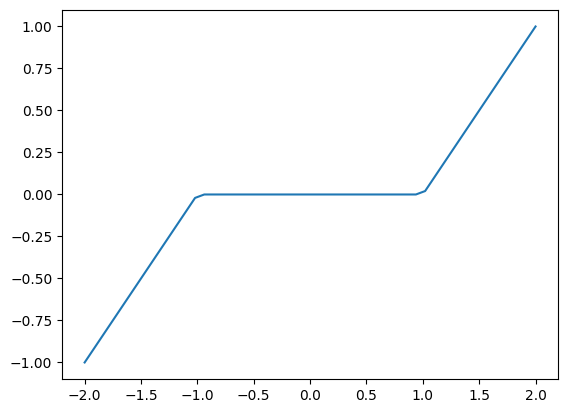

In [70]:
x = np.linspace(-2, 2)
plt.plot(x, soft_thresholding(x, 1))
plt.show()

**Exercise 3** Demonstrate that if $\lambda \geq \lambda_{\max} := \max_{i=1, \dots, p} |(X^{\top}y)_i|$ then $0$ is a solution of the Lasso. 


As a consequence, we take for $\lambda$ a fraction of $\lambda_{\max}$, for instance $\lambda = 0.5 \lambda_{\max}$:

In [71]:
lambda_max = np.max(np.abs(X.T.dot(y)))
lbda = 0.5 * lambda_max

**Exercise 4** Implement proximal gradient descent with a step size `step` for `n_iters` iterations, starting from $w^0=0$.  Display the evolution of $f(x_n) - f^*$ for this problem, with 100 iterations and the classical step-size $1/L$. You can compute $f^*$ by running the algorithm for many iterations.

In [72]:
def proximal_gradient_descent(X, y, lbda, step, n_iters):
    n, p = X.shape
    w = np.zeros(p)
    w_list = []
    for i in range(n_iters):
        w_list.append(w.copy())
        w = soft_thresholding(w - step * lasso_gradient(w, X, y), lbda * step)
    return w, w_list  # returns the value of w and the list of iterates

In [73]:
step = 1 / np.linalg.eigvalsh(X.T @ X)[-1]
n_iters = 100
w, w_list = proximal_gradient_descent(X, y, lbda, step, n_iters)

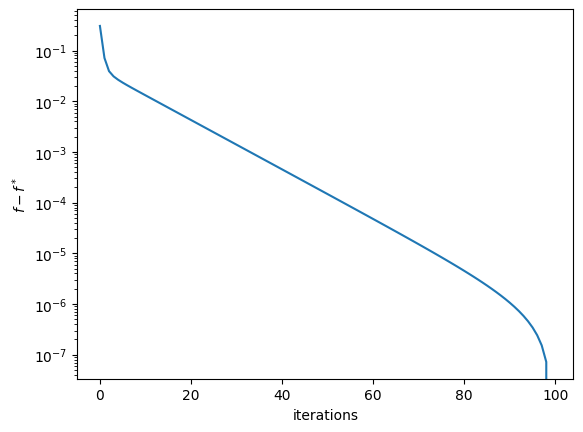

In [74]:
f_vals = np.array([lasso_cost(w, X, y, lbda) for w in w_list])
f_star = np.min(f_vals)

plt.semilogy(f_vals - f_star)
plt.xlabel('iterations')
plt.ylabel(r'$f - f^*$')
plt.show()

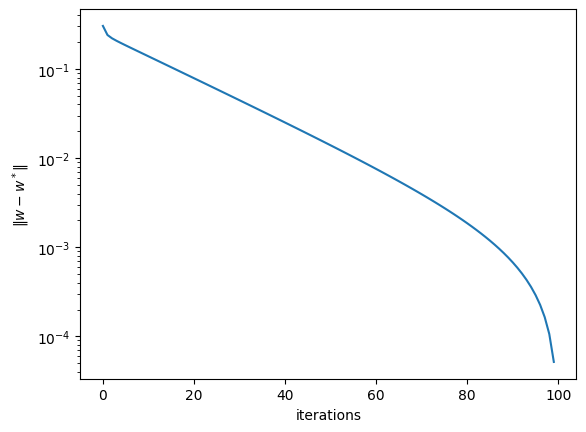

In [75]:
w_star = w
dists = np.array([np.linalg.norm(w - w_star) for w in w_list])

plt.semilogy(dists)
plt.xlabel('iterations')
plt.ylabel(r'$\|w - w^*\|$')
plt.show()

**Exercise 5** what do you notice about the optimal $w$?

In [76]:
def sparsity(w, tol=1e-7):
    return np.sum(np.abs(w) > tol)

In [77]:
sparsity(w_star)

3

**Exercise 6** Generate a problem with $n=50$, $p=100$ where the conditioning is $~1 / 100$. For various values of $\lambda$, what convergence curves do you see?

Sparsity for lambda = 0.12 is 37
Sparsity for lambda = 0.39 is 19
Sparsity for lambda = 0.66 is 7
Sparsity for lambda = 0.94 is 4


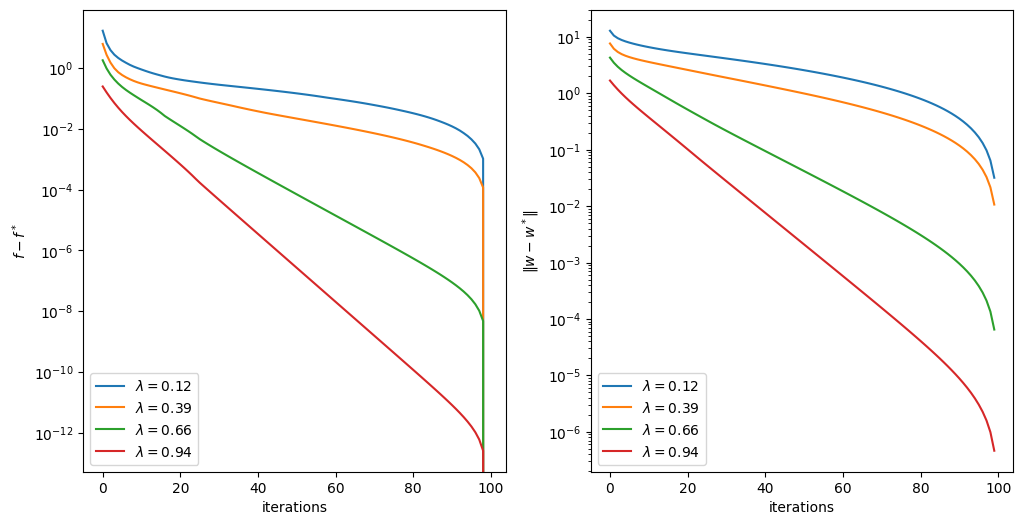

In [78]:
n, p = 50, 100

y = np.random.randn(n)

singular_values = np.linspace(1e-2, 1, n)
U, _, V = np.linalg.svd(np.random.randn(n, p), full_matrices=False)
X = np.dot(U * singular_values, V)   # badly conditioned matrix

lambda_max = np.max(np.abs(X.T.dot(y)))
step = 1 / np.linalg.eigvalsh(X.T @ X)[-1]
n_iters = 100

# plot
lbdas = np.linspace(0.1, 0.8, 4) * lambda_max

f, axes = plt.subplots(1, 2, figsize=(12, 6))
for lbda in lbdas:
    w, w_list = proximal_gradient_descent(X, y, lbda, step, n_iters)
    f_vals = np.array([lasso_cost(w, X, y, lbda) for w in w_list])
    f_star = np.min(f_vals)
    axes[0].semilogy(f_vals - f_star, label=f'$\lambda = {lbda:.2f}$')
    w_star = w
    print(f"Sparsity for lambda = {lbda:.2f} is", sparsity(w_star))
    dists = [np.linalg.norm(w - w_star) for w in w_list]
    axes[1].semilogy(dists, label=f'$\lambda = {lbda:.2f}$')
axes[0].set_xlabel('iterations')
axes[0].set_ylabel(r'$f - f^*$')
axes[1].set_xlabel('iterations')
axes[1].set_ylabel(r'$\|w - w^*\|$')
axes[0].legend()
axes[1].legend()
plt.show()

# Different regularizations

We now consider $A$ a $p \times p$ matrix, and consider the problem
$$
\min_{w} \frac12\|Xw - y\|^2 + \lambda \|Aw\|_1
$$

In order to implement the proximal gradient descent, we need to compute the proximal operator of the second term.

We define $R(w) = \lambda\|Aw\|_1$.

**Exercise 7** Assume that $A$ is diagonal with coefficients $a_1, \dots, a_p$. What is $\mathrm{prox}_R(w)$?

**Exercise 8** Assume that $A$ is orthogonal, i.e. $A^{\top}$ is the inverse of $A$. What is $\mathrm{prox}_R(w)$?

**Exercise 9** In general, when $A$ is neither diagonal nor orthogonal, we do not have a closed-form expression of the proximal operator of $R$. 

We can instead resort once again to an iterative algorithm to compute it.


Prove that $\mathrm{prox}_{\lambda R(w)} = A^{-1} \phi(w, A^{-1}, \lambda)$ where $\phi(w, B, \lambda) = \arg\min_z \frac12\|Bz - w\|^2 +\lambda \|z\|_1$

What problem do you recognize? 

# Singular Value Soft Thresholding

Consider the extension of proximal operators to matrices
$$\mathrm{prox}_F(A) := \mathrm{argmin}_{X\in \mathbb{R}^{d\times d}}\frac12 \|X - A\|^2_F + F(X).$$
Denote $\|\cdot \|_*$ the nuclear norm:
$$\|X \|_* := \sum_{i=1}^d \sigma_i(X),$$
where the $\sigma_i(X)$ are the singular values of $X$.

**Exercise 10** Prove that
$$\mathrm{prox}_{\lambda \|\cdot\|_*}(A) = U \mathrm{diag}(S_\lambda(\sigma(A)))V^\top,$$
where $A = U \mathrm{diag}(\sigma(A))V^\top$ is the SVD of $A$.
You mave use the following result by Von Neumann (1937): for any matrices $A, X$ of the same shape, we have
$$\langle X, A\rangle \le \langle \mathrm{diag}(\sigma(A)), \mathrm{diag}(\sigma(X))\rangle,$$
with equality if $A$ and $X$ have the same singular vectors.